<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use(style = "ggplot")
plt.rcParams['figure.figsize'] = [10,6]

print(__doc__)

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_boston
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
import pandas as pd


sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


#import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification



from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn import linear_model
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler


Automatically created module for IPython interactive environment


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on #fixed characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [3]:
## EDA
# Load the data
house = pd.read_csv('./housing.csv')

In [4]:
house.shape

(1460, 81)

In [4]:
# salesprice skewness
#sns.distplot([house.SalePrice], hist = True, kde = True)

In [5]:
#plt.hist(house.SalePrice,color = 'Blue' )

In [6]:
#house.kurtosis()
#house.skew(axis = 0, skipna = True)
#house.SalePrice.describe()

In [5]:
house.SalePrice.skew()     ### positive skew

1.8828757597682129

In [14]:
## do target log transform...np.log..better linearity
##at end  reverse..np.exp
target = np.log(house.SalePrice)
#plt.hist(target,color = 'Blue' )
#target.skew()  #### value closer to zero indicates better skew with log values...

In [11]:
numeric_features = house.select_dtypes(include=[np.number])

In [12]:
# displays the correlation between the features columns and the target.
corr = numeric_features.corr()
corr['SalePrice'].sort_values(ascending=False)[:20]

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
Name: SalePrice, dtype: float64

In [13]:
corr['SalePrice'].sort_values(ascending=False)[-20:]

BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
Condition2       0.051079
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
Condition1      -0.013506
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
Neighborhood    -0.034527
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

In [15]:
house.OverallQual.unique()

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2])

In [17]:
OverallQualPivot = house.pivot_table(values = "SalePrice", index ='OverallQual', aggfunc = np.median)
#OverallQualPivot

(array([ 0.,  2.,  4.,  6.,  8., 10., 12.]),
 <a list of 7 Text xticklabel objects>)

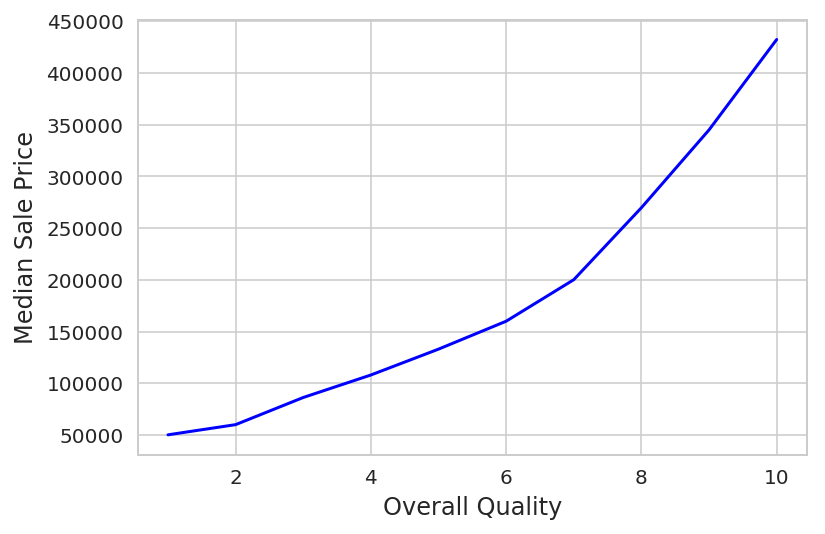

In [19]:
plt.plot(OverallQualPivot, color = 'Blue')
plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
#plt.show()

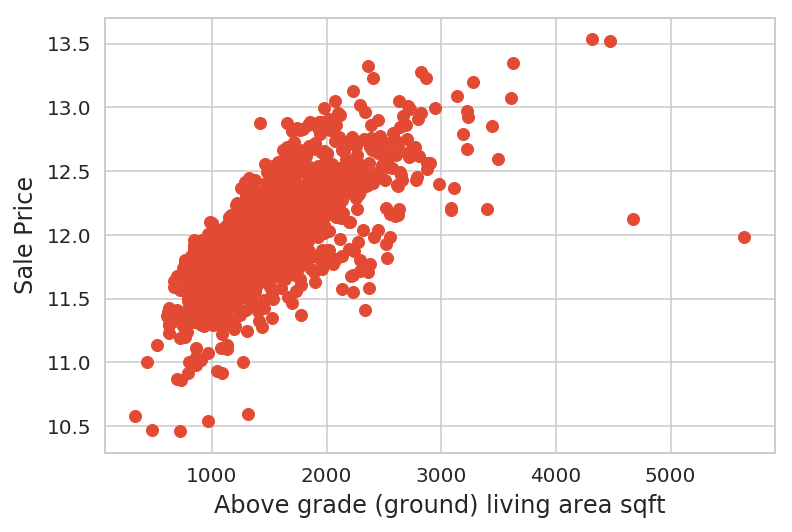

In [20]:
#to generate some scatter plots and visualize the relationship between the Ground Living Area(GrLivArea) and SalePrice
plt.scatter(x= house['GrLivArea'], y=target)
plt.ylabel('Sale Price')
plt.xlabel('Above grade (ground) living area sqft')
plt.show()


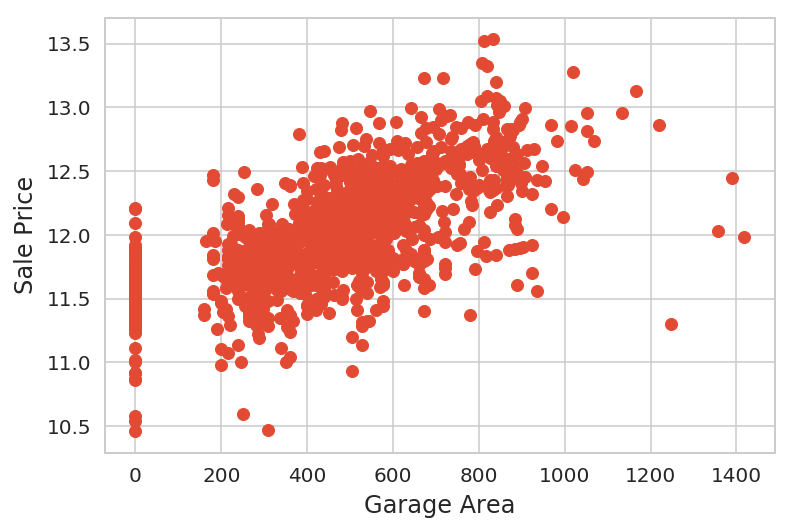

In [21]:
# do the same for GarageArea.
plt.scatter(x=house['GarageArea'], y=target)
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.show()


In [17]:
#house.GarageArea.unique()   #### has outliers..1200 -1400 sqft

In [18]:
#house.isnull().sum()   ### look at null values

In [22]:
cols_with_na = pd.DataFrame(house.isnull().sum().sort_values(ascending=False)[:25])
cols_with_na.columns = ['NA Count']
cols_with_na.index.name = 'Feature'

cols_with_na

,NA Count
Feature,
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
FireplaceQu,690
LotFrontage,259
GarageCond,81
GarageType,81
GarageYrBlt,81


In [23]:
house.MiscFeature.unique()   #### MiscFeature with dollar values of renvoations, Tennis court

array([nan, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

In [25]:
#CLEANING NAN VALUES
#1  Non numericfeatures where NaN values have meaning e.g. no pool etc.
cols_fill_na = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2']

# replace 'NaN' with 'None' in these columns
for col in cols_fill_na:
    house[col].fillna('None',inplace=True)
        

In [26]:
#GarageYrBlt nans: no garage. replace with property YearBuilt.
#(more appropriate than 0, which is ~2000 away from all other values)
house.loc[house.GarageYrBlt.isnull(),'GarageYrBlt'] = house.loc[house.GarageYrBlt.isnull(),'YearBuilt']


#No masonry veneer - fill area with 0
house.MasVnrArea.fillna(0,inplace=True)

#No basement - fill areas/counts with 0    
house.BsmtFullBath.fillna(0,inplace=True)
house.BsmtHalfBath.fillna(0,inplace=True)
house.BsmtFinSF1.fillna(0,inplace=True)
house.BsmtFinSF2.fillna(0,inplace=True)
house.BsmtUnfSF.fillna(0,inplace=True)
house.TotalBsmtSF.fillna(0,inplace=True)

#No garage - fill areas/counts with 0
house.GarageArea.fillna(0,inplace=True)
house.GarageCars.fillna(0,inplace=True)

house[cols_fill_na].head(5)

,PoolQC,MiscFeature,Alley,Fence,MasVnrType,FireplaceQu,GarageQual,GarageCond,GarageFinish,GarageType,BsmtExposure,BsmtCond,BsmtQual,BsmtFinType1,BsmtFinType2
0,None,None,None,None,BrkFace,None,TA,TA,RFn,Attchd,No,TA,Gd,GLQ,Unf
1,None,None,None,None,None,TA,TA,TA,RFn,Attchd,Gd,TA,Gd,ALQ,Unf
2,None,None,None,None,BrkFace,TA,TA,TA,RFn,Attchd,Mn,TA,Gd,GLQ,Unf
3,None,None,None,None,None,Gd,TA,TA,Unf,Detchd,No,Gd,TA,ALQ,Unf
4,None,None,None,None,BrkFace,TA,TA,TA,RFn,Attchd,Av,TA,Gd,GLQ,Unf


In [27]:
# LotFrontage NAN values
house.LotFrontage.fillna(0,inplace=True)

In [28]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [29]:
house.OverallQual.unique(), 

(array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2]),)

In [30]:
house.OverallCond.unique()

array([5, 8, 6, 7, 4, 2, 3, 9, 1])

In [31]:
house.Neighborhood.unique()

array([ 5. ,  2.5, 10. ,  7. ])

In [8]:
# flood plain rating
house['Neighborhood'].replace({'CollgCr':5, 'Veenker':2.5, 'Crawfor' :10, 'NoRidge':10, 'Mitchel': 2.5, 'Somerst':10,
       'NWAmes' : 10, 'OldTown': 10, 'BrkSide':10, 'Sawyer':10, 'NridgHt':10, 'NAmes':10,
       'SawyerW': 10 , 'IDOTRR': 10, 'MeadowV': 7, 'Edwards':10, 'Timber':10, 'Gilbert':5,
       'StoneBr':10, 'ClearCr':10, 'NPkVill':10, 'Blmngtn':10, 'BrDale':10, 'SWISU':10,
       'Blueste':10}, inplace=True)





Artery	Adjacent to arterial street                           7
       Feedr	Adjacent to feeder street	                  6
       Norm	Normal	                                          5
       RRNn	Within 200' of North-South Railroad        1
       RRAn	Adjacent to North-South Railroad           1  
       PosN	Near positive off-site feature--park, greenbelt, etc.   10
       PosA	Adjacent to postive off-site feature                     10  
       RRNe	Within 200' of East-West Railroad                   1
       RRAe	Adjacent to East-West Railroad                       1
       
       
       An arterial road or arterial thoroughfare is a high-capacity urban road. 
       The term feeder road can refer to one of several related types of thoroughfare: A secondary road which "feeds" traffic to main highways and freeways. A frontage road, that is, a road which runs parallel with high-speed roads, allowing easier access to local amenities.

In [29]:
house.Condition1.unique()

array(['Norm', 'Feedr', 'PosN', 'Artery', 'RRAe', 'RRNn', 'RRAn', 'PosA',
       'RRNe'], dtype=object)

In [9]:
house['Condition1'].replace({'Norm':5, 'Feedr':6, 'PosN':10, 'Artery':7, 'RRAe':1, 'RRNn':1, 'RRAn':1, 'PosA':10,
       'RRNe':1}, inplace=True)

# Norm - 10
#  RR - 3

In [31]:
house.Condition2.unique()

array(['Norm', 'Artery', 'RRNn', 'Feedr', 'PosN', 'PosA', 'RRAn', 'RRAe'],
      dtype=object)

In [10]:
house['Condition2'].replace({'Norm':5, 'Feedr':6, 'PosN':10, 'Artery':7, 'RRAe':1, 'RRNn':1, 'RRAn':1, 'PosA':10,
       'RRNe':1}, inplace=True)
#


In [32]:
# convert some categorical values to numeric scales

#Excellent, Good, Typical, Fair, Poor, None: Convert to 0-5 scale
cols_Ex_None = ['ExterQual','ExterCond','BsmtQual','BsmtCond',
             'HeatingQC','KitchenQual','FireplaceQu','GarageQual',
            'GarageCond','PoolQC']

dict_Ex_None = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0}

for col in cols_Ex_None:
    house[col].replace(dict_Ex_None, inplace=True)

#house[cols_Ex_None].head(5)   

# Remaining columns
house['BsmtExposure'].replace({'Gd':4,'Av':3,'Mn':2,'No':1,'None':0}, inplace=True)

house['CentralAir'].replace({'Y':1,'N':0}, inplace=True)

house['Functional'].replace({'Typ':7,'Min1':6,'Min2':5,'Mod':4,'Maj1':3,'Maj2':2,'Sev':1,'Sal':0}, inplace=True)

house['GarageFinish'].replace({'Fin':3,'RFn':2,'Unf':1,'None':0}, inplace=True)

house['LotShape'].replace({'Reg':3,'IR1':2,'IR2':1,'IR3':0}, inplace=True)

house['Utilities'].replace({'AllPub':3,'NoSewr':2,'NoSeWa':1,'ELO':0}, inplace=True)

house['LandSlope'].replace({'Gtl':2,'Mod':1,'Sev':0}, inplace=True)

In [33]:
house[cols_Ex_None].head(5)   

,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC
0,4,3,4,3,5,4,0,3,3,0
1,3,3,4,3,5,3,3,3,3,0
2,4,3,4,3,5,4,3,3,3,0
3,3,3,3,4,4,4,4,3,3,0
4,4,3,4,3,5,4,3,3,3,0


In [35]:
#Business question:  Develop an algorithm to reliably estimate the value of residential houses 
###based on #fixed characteristics.  >>> Call it  value_fixed 
### 1) Plan  - this step
# 2)Understand the business question
# 3) read the data dictionary
# 4) What all are fixed characteristics of the house that can predict price
#The neighborhood, Square feet, Bedrooms, bathrooms, Basement and garage space
#  renovatable features:  Identify fixed features that can predict price.
#Roof and exterior features
#"Quality" metrics, such as kitchen quality
#"Condition" metrics, such as condition of garage
#Heating and electrical components
#and generally anything you deem can be modified without #having to undergo major construction on the house.
#####  Use Lasso with cross validation to get the 10 fixed variables

### remove any non - residential   -  remove all rows based on non residential from MSZoning column 


In [34]:
# consider the non-numeric features 
categoricals = house.select_dtypes(exclude=[np.number])
#print(categoricals.describe())

In [37]:
#to remove skew
#  keep only residential houses     
# remove all plots > 4000 sqft lot area
# remove all houses with GRLIVAREA > 1500
# remove all houses with salecondition not normal

In [35]:
r_house = house[house.MSZoning != 'C (all)']
r_house.MSZoning.value_counts() 

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

In [39]:
r_house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 81 columns):
Id               1450 non-null int64
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1450 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            1450 non-null object
LotShape         1450 non-null int64
LandContour      1450 non-null object
Utilities        1450 non-null int64
LotConfig        1450 non-null object
LandSlope        1450 non-null int64
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-nu

In [48]:
r_house.describe()

,Id,MSSubClass,LotFrontage,LotArea,LotShape,Utilities,LandSlope,Neighborhood,Condition1,Condition2,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,SalePrice
count,1450.000000,1450.000000,1450.00000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,...,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000
mean,731.364138,56.903448,57.54000,10523.831724,2.589655,2.998621,1.939310,8.864828,5.092414,5.005517,...,46.537931,21.536552,3.433103,15.096552,2.777931,0.017931,43.365517,6.312414,2007.812414,181654.942069
std,421.554345,42.265033,34.71992,10012.185355,0.583205,0.052523,0.273842,2.257494,1.063095,0.323836,...,65.222761,60.838826,29.416948,55.893399,40.315051,0.269874,497.636495,2.698244,1.326321,79176.485241
min,1.000000,20.000000,0.00000,1300.000000,0.000000,1.000000,0.000000,2.500000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,37900.000000
25%,366.250000,20.000000,41.25000,7544.500000,2.000000,3.000000,2.000000,10.000000,5.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130000.000000
50%,731.500000,50.000000,63.00000,9496.000000,3.000000,3.000000,2.000000,10.000000,5.000000,5.000000,...,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163945.000000
75%,1096.750000,70.000000,79.00000,11613.500000,3.000000,3.000000,2.000000,10.000000,5.000000,5.000000,...,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.00000,215245.000000,3.000000,3.000000,2.000000,10.000000,10.000000,10.000000,...,547.000000,552.000000,508.000000,480.000000,738.000000,5.000000,15500.000000,12.000000,2010.000000,755000.000000


In [36]:
r_house.shape

(1450, 81)

In [53]:
r_house_filt_lux = r_house[(r_house.LotArea > 4000) & (r_house.SalePrice > 200000)]
#& house.SaleCondition == 'normal'] 

In [54]:
r_house_filt_lux.shape

(422, 81)

In [56]:
#r_house_filt_lux.LotArea.value_counts()

In [49]:
#r_house_filt_lux.SalePrice.unique()

In [50]:
#r_house_filt_lux

In [44]:
#r_house_filt1 = r_house_filt[r_house_filt.GrLivArea < 1500]

In [57]:
r_house_filt_lux.shape

(422, 81)

In [59]:
r_house_filt_lux.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,3,Lvl,3,...,0,0,None,None,0,2,2008,WD,Normal,208500
2,3,60,RL,68.0,11250,Pave,None,2,Lvl,3,...,0,0,None,None,0,9,2008,WD,Normal,223500
4,5,60,RL,84.0,14260,Pave,None,2,Lvl,3,...,0,0,None,None,0,12,2008,WD,Normal,250000
6,7,20,RL,75.0,10084,Pave,None,3,Lvl,3,...,0,0,None,None,0,8,2007,WD,Normal,307000
11,12,60,RL,85.0,11924,Pave,None,2,Lvl,3,...,0,0,None,None,0,7,2006,New,Partial,345000


In [62]:
r_house_filt_lux.SaleCondition.value_counts()

Normal     315
Partial     87
Abnorml     13
Alloca       4
Family       3
Name: SaleCondition, dtype: int64

In [65]:
r_house_final_lux = r_house_filt_lux[r_house_filt_lux['SaleCondition'] == 'Normal']

In [66]:
r_house_final_lux.shape

(315, 81)

In [67]:
r_house_final_lux

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,3,Lvl,3,...,0,0,None,None,0,2,2008,WD,Normal,208500
2,3,60,RL,68.0,11250,Pave,None,2,Lvl,3,...,0,0,None,None,0,9,2008,WD,Normal,223500
4,5,60,RL,84.0,14260,Pave,None,2,Lvl,3,...,0,0,None,None,0,12,2008,WD,Normal,250000
6,7,20,RL,75.0,10084,Pave,None,3,Lvl,3,...,0,0,None,None,0,8,2007,WD,Normal,307000
22,23,20,RL,75.0,9742,Pave,None,3,Lvl,3,...,0,0,None,None,0,9,2008,WD,Normal,230000
25,26,20,RL,110.0,14230,Pave,None,3,Lvl,3,...,0,0,None,None,0,7,2009,WD,Normal,256300
27,28,20,RL,98.0,11478,Pave,None,3,Lvl,3,...,0,0,None,None,0,5,2010,WD,Normal,306000
28,29,20,RL,47.0,16321,Pave,None,2,Lvl,3,...,0,0,None,None,0,12,2006,WD,Normal,207500
34,35,120,RL,60.0,7313,Pave,None,3,Lvl,3,...,0,0,None,None,0,8,2007,WD,Normal,277500
35,36,60,RL,108.0,13418,Pave,None,3,Lvl,3,...,0,0,None,None,0,9,2006,WD,Normal,309000


POPULAR NEIGHBORHOODS IN AMES

City Center
24th St / Grand Ave
Woodland St / West St
Grand Ave / 30th St
Stange Rd / Pammel Ct
E 13Th St / Duff Ave
S Duff Ave / E Lincoln Way
Iowa State U / N Hyland Ave
S Duff Ave / Airport Rd
Lincoln Way / 500th Ave

In [51]:
r_house_final.Neighborhood.unique()

array(['MeadowV', 'Somerst', 'Edwards', 'NPkVill', 'OldTown', 'BrDale',
       'Blmngtn', 'NridgHt', 'Blueste', 'ClearCr', 'StoneBr', 'IDOTRR',
       'Crawfor'], dtype=object)

In [70]:
house_fixed_col =  ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle',  'YearBuilt', 'YearRemodAdd',
       'RoofStyle',  'Exterior1st',  'MasVnrType',
       'MasVnrArea',  'Foundation', 'GarageCars',
         'TotalBsmtSF', 
       '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea',  
        'Functional',         
         'MoSold', 'YrSold', 'SaleType',
       'SaleCondition', 'SalePrice']

In [71]:
r_house_fixed = r_house_final_lux[house_fixed_col]
r_house_fixed.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,...,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,Functional,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,3,Lvl,Inside,...,856,854,0,1710,7,2,2008,WD,Normal,208500
2,3,60,RL,68.0,11250,Pave,None,2,Lvl,Inside,...,920,866,0,1786,7,9,2008,WD,Normal,223500
4,5,60,RL,84.0,14260,Pave,None,2,Lvl,FR2,...,1145,1053,0,2198,7,12,2008,WD,Normal,250000
6,7,20,RL,75.0,10084,Pave,None,3,Lvl,Inside,...,1694,0,0,1694,7,8,2007,WD,Normal,307000
22,23,20,RL,75.0,9742,Pave,None,3,Lvl,Inside,...,1795,0,0,1795,7,9,2008,WD,Normal,230000


In [73]:
### feature selection..
numeric_fixed_lux = r_house_fixed.select_dtypes(include=[np.number])
numeric_fixed_lux.head(5)

,Id,MSSubClass,LotFrontage,LotArea,LotShape,LandSlope,Neighborhood,Condition1,Condition2,YearBuilt,...,GarageCars,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,Functional,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,3,2,5.0,5,5,2003,...,2,856,856,854,0,1710,7,2,2008,208500
2,3,60,68.0,11250,2,2,5.0,5,5,2001,...,2,920,920,866,0,1786,7,9,2008,223500
4,5,60,84.0,14260,2,2,10.0,5,5,2000,...,3,1145,1145,1053,0,2198,7,12,2008,250000
6,7,20,75.0,10084,3,2,10.0,5,5,2004,...,2,1686,1694,0,0,1694,7,8,2007,307000
22,23,20,75.0,9742,3,2,5.0,5,5,2002,...,2,1777,1795,0,0,1795,7,9,2008,230000


In [74]:
r_house_train_lux = numeric_fixed[numeric_fixed['YrSold'] < 2010]

r_house_test_lux = numeric_fixed[numeric_fixed['YrSold'] == 2010]

In [76]:
r_house_test_lux.shape

(46, 22)

In [77]:
r_house_train_lux.shape

(269, 22)

In [78]:
#r_house_train_final = r_house_train.fillna(0)
r_house_train_final_lux = r_house_train_lux

In [79]:
X_train = r_house_train_final_lux.drop(['SalePrice'],axis =1)

y_train = np.log(r_house_train_lux.SalePrice.values)


In [81]:
#temp = np.log(r_house_train['SalePrice'])
y_train.shape = (269,1)
y_train

array([[12.24769432],
       [12.31716669],
       [12.4292162 ],
       [12.63460303],
       [12.34583459],
       [12.45410391],
       [12.24288662],
       [12.53357621],
       [12.64109656],
       [12.42801548],
       [12.86099861],
       [12.21849517],
       [12.29910751],
       [12.66665705],
       [12.32829028],
       [12.32385568],
       [12.4049235 ],
       [12.40901349],
       [12.46843691],
       [12.229545  ],
       [12.27373129],
       [12.4292162 ],
       [12.46651198],
       [12.32829028],
       [12.4049235 ],
       [12.30138283],
       [12.34583459],
       [12.35233515],
       [12.46843691],
       [12.22587527],
       [12.36734079],
       [12.92999148],
       [12.33710091],
       [12.38421883],
       [12.40081672],
       [12.25961341],
       [12.20657252],
       [13.07107008],
       [12.56374709],
       [12.66032792],
       [12.52416267],
       [12.53177279],
       [12.25486281],
       [12.64915462],
       [12.86424011],
       [12

In [82]:
X_train.shape

(269, 21)

In [83]:
## linear regression for fixed
##instantiate the model.
lr = linear_model.LinearRegression(normalize = True)

#  Model fitting

model = lr.fit(X_train, y_train)

In [63]:
###Doing all data wrangling for X_test, y_test as for train

In [84]:
#r_house_test_final = r_house_test.fillna(0)
r_house_test_final_lux = r_house_test_lux

In [86]:
X_test = r_house_test_final_lux.drop(['SalePrice'],axis =1)

In [87]:
predictions = model.predict(X_test)
predictions

array([[12.53993893],
       [12.53347514],
       [12.35856279],
       [12.82379641],
       [12.34921657],
       [12.36039645],
       [12.20540301],
       [12.29923865],
       [12.37033641],
       [12.39052581],
       [12.6020558 ],
       [12.35074727],
       [12.59977503],
       [12.33481297],
       [12.34363996],
       [12.39075552],
       [12.38066306],
       [12.36585548],
       [12.38832002],
       [12.3185049 ],
       [12.422899  ],
       [12.43463015],
       [12.23595344],
       [12.96911722],
       [12.38239657],
       [12.42966114],
       [12.32067194],
       [12.35858347],
       [12.23573143],
       [12.20716979],
       [12.30065075],
       [12.18708111],
       [12.31205494],
       [12.52899317],
       [12.61945187],
       [12.51501221],
       [12.47211855],
       [12.67255833],
       [12.35759831],
       [12.4606663 ],
       [12.69207511],
       [12.96931298],
       [12.22366864],
       [12.425501  ],
       [12.41878682],
       [12

In [89]:
y_test = np.log(r_house_test_final_lux.SalePrice.values)
y_test

array([12.63134038, 12.67576373, 12.23076526, 12.67607627, 12.31268238,
       12.44862659, 12.27839331, 12.28534583, 12.47800636, 12.23076526,
       12.5776362 , 12.21106019, 12.39669301, 12.22046853, 12.26434155,
       12.57418197, 12.51355735, 12.27373129, 12.30591798, 12.26904744,
       12.37370349, 12.46997419, 12.27932311, 13.19561384, 12.35879373,
       12.32341114, 12.37581542, 12.37158708, 12.20856953, 12.40656151,
       12.27792808, 12.23563145, 12.27139211, 12.70076889, 12.69158046,
       12.41044104, 12.4049235 , 12.84397135, 12.46843691, 12.72188581,
       12.71640215, 12.92391244, 12.28303369, 12.35449265, 12.25486281,
       12.49312952])

In [90]:
# ---- Evaluate Model performance and visualize results
# r-squared value is a measure of how close the data are to the fitted regression line
# a higher r-squared value means a better fit(very close to value 1)
print("R^2 is: \n", model.score(X_test, y_test))


print('RMSE is: ')
mean_squared_error(y_test, predictions)

R^2 is: 
 0.7144934915691339
RMSE is: 


0.012987085750250493

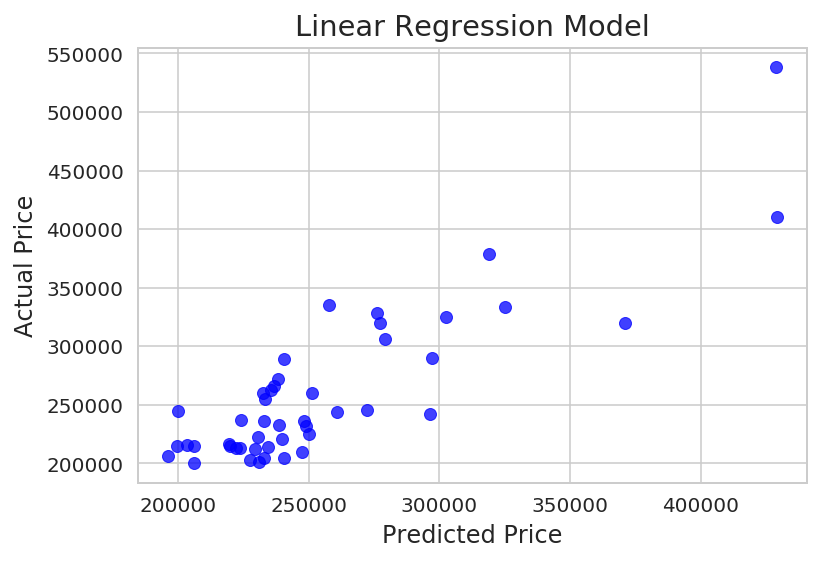

In [91]:
actual_values = y_test
  
            
plt.scatter(np.exp(predictions), np.exp(actual_values), alpha=.75, color='b')  # alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

In [92]:
print(np.exp(predictions))
print('/n')
print(np.exp(actual_values))

[[279271.28418365]
 [277471.95371441]
 [232946.19753883]
 [370940.29770799]
 [230779.17350358]
 [233373.73321104]
 [199866.11799935]
 [219528.78784836]
 [235705.02575341]
 [240512.13103341]
 [297168.85625379]
 [231132.69711241]
 [296491.85473885]
 [227478.94664175]
 [229495.79004404]
 [240567.38666959]
 [238151.68094325]
 [234651.21126699]
 [239982.19757063]
 [223799.29000703]
 [248425.67959689]
 [251357.16002227]
 [206066.3401486 ]
 [428959.25654969]
 [238564.87710309]
 [250111.26115522]
 [224284.7983739 ]
 [232951.01370645]
 [206020.59791508]
 [200219.549723  ]
 [219839.00257235]
 [196237.53352404]
 [222360.43855754]
 [276231.1143864 ]
 [302383.65361342]
 [272396.01152932]
 [260958.99154179]
 [318876.2354332 ]
 [232721.63224462]
 [257987.47040733]
 [325160.80028885]
 [429043.23602787]
 [203550.34290303]
 [249072.92305007]
 [247406.20398036]
 [236690.80023448]]
/n
[306000. 319900. 205000. 320000. 222500. 254900. 215000. 216500. 262500.
 205000. 290000. 201000. 242000. 202900. 212000. 

In [93]:
# Appending the predicted values to the  housing dataframe to do DF calcs


#Add predicted values to fixed_char_ DF
Fixed_Predictions = model.predict(X_train)

r_house_train_final_lux['FixedPredicted'] = np.exp(Fixed_Predictions)


/Users/pramodpaul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [94]:
Fixed_Predictions

array([[12.2623353 ],
       [12.32136562],
       [12.58411282],
       [12.43533434],
       [12.46484931],
       [12.53280256],
       [12.25692013],
       [12.45220041],
       [12.61055556],
       [12.49787043],
       [12.52926259],
       [12.38733985],
       [12.38328109],
       [12.63586441],
       [12.33015265],
       [12.3256485 ],
       [12.64111401],
       [12.50951943],
       [12.506497  ],
       [12.2643586 ],
       [12.37421115],
       [12.44827533],
       [12.43540637],
       [12.30479144],
       [12.36702989],
       [12.25022252],
       [12.45912395],
       [12.28731425],
       [12.40583148],
       [12.33212916],
       [12.16396418],
       [12.79357356],
       [12.39071068],
       [12.35301092],
       [12.43677377],
       [12.41313161],
       [12.01683612],
       [12.86263943],
       [12.43198023],
       [12.48022015],
       [12.52474355],
       [12.44431245],
       [12.30566263],
       [12.34250359],
       [12.88143055],
       [12

In [95]:
# Residuals equals the difference between Y-True and Y-Pred
r_house_train_final_lux['Residuals'] = abs(r_house_train_final_lux['SalePrice']- r_house_train_final_lux['FixedPredicted'])

/Users/pramodpaul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [73]:
#r_house_train_final.head(10)
#r_house_train_final.drop('Predicted', axis = 1, inplace = True)

In [96]:
r_house_train_final_lux

,Id,MSSubClass,LotFrontage,LotArea,LotShape,LandSlope,Neighborhood,Condition1,Condition2,YearBuilt,...,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,Functional,MoSold,YrSold,SalePrice,FixedPredicted,Residuals
0,1,60,65.0,8450,3,2,5.0,5,5,2003,...,856,854,0,1710,7,2,2008,208500,211575.099892,3075.099892
2,3,60,68.0,11250,2,2,5.0,5,5,2001,...,920,866,0,1786,7,9,2008,223500,224440.433252,940.433252
4,5,60,84.0,14260,2,2,10.0,5,5,2000,...,1145,1053,0,2198,7,12,2008,250000,291884.315331,41884.315331
6,7,20,75.0,10084,3,2,10.0,5,5,2004,...,1694,0,0,1694,7,8,2007,307000,251534.223784,55465.776216
22,23,20,75.0,9742,3,2,5.0,5,5,2002,...,1795,0,0,1795,7,9,2008,230000,259068.894706,29068.894706
25,26,20,110.0,14230,3,2,10.0,5,5,2007,...,1600,0,0,1600,7,7,2009,256300,277285.393369,20985.393369
28,29,20,47.0,16321,2,2,10.0,5,5,1957,...,1600,0,0,1600,7,12,2006,207500,210432.482714,2932.482714
34,35,120,60.0,7313,3,2,10.0,5,5,2005,...,1561,0,0,1561,7,8,2007,277500,255812.597640,21687.402360
35,36,60,108.0,13418,3,2,10.0,5,5,2004,...,1132,1320,0,2452,7,9,2006,309000,299705.487711,9294.512289
47,48,20,84.0,11096,3,2,10.0,5,5,2006,...,1656,0,0,1656,7,7,2007,249700,267766.450266,18066.450266


In [97]:
r_house_train_final_lux.shape

(269, 24)

In [98]:
r_house_test_final_lux['FixedPredicted'] = np.exp(predictions)

/Users/pramodpaul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [99]:
r_house_test_final_lux['Residuals'] = abs(r_house_test_final_lux['SalePrice']-r_house_test_final_lux['FixedPredicted'])

/Users/pramodpaul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [77]:
#r_house_test_final.drop('Predicted', axis = 1, inplace = True)

In [100]:
r_house_test_final_lux.shape

(46, 24)

Neighborhood: Physical locations within Ames city limits
                                                  Add flood plain overlay
       Blmngtn	Bloomington Heights                      
       Blueste	Bluestem
       BrDale	Briardale
       BrkSide	Brookside
       ClearCr	Clear Creek
       CollgCr	College Creek
       Crawfor	Crawford
       Edwards	Edwards
       Gilbert	Gilbert
       IDOTRR	Iowa DOT and Rail Road
       MeadowV	Meadow Village
       Mitchel	Mitchell
       Names	North Ames
       NoRidge	Northridge
       NPkVill	Northpark Villa
       NridgHt	Northridge Heights
       NWAmes	Northwest Ames
       OldTown	Old Town
       SWISU	South & West of Iowa State University
       Sawyer	Sawyer
       SawyerW	Sawyer West
       Somerst	Somerset
       StoneBr	Stone Brook
       Timber	Timberland
       Veenker	Veenker

In [102]:
### concat both dataframes together  ...new Df = df1.append(df2)
r_house_fixed_combined_lux =    r_house_train_final_lux.append(r_house_test_final_lux)

In [80]:
##do standardisation
#scaler = StandardScaler.fit(X_train)
#standardised_X = scaler.transform(X_train)
#standardised_X_test = scaler.transform(X_test)
#scaler = StandardScaler.fit(X)
#standardised_X = scaler.transform(X)
#standardised_X_test = scaler.transform(X_test)



<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [103]:

#Some examples of things that ARE renovate-able:
#Roof and exterior features
#"Quality" metrics, such as kitchen quality
#"Condition" metrics, such as condition of garage
#Heating and electrical components
#and generally anything you deem can be modified without having to undergo major construction on the house.


house_var_col = ['Id', 'Neighborhood',  'Utilities', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 
'RoofStyle', 'RoofMatl',  'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',  'BsmtQual',
'BsmtCond', 'BsmtFinType2', 'BsmtUnfSF',  'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 
        'BsmtHalfBath', 
       'HalfBath',   'KitchenQual',
       'TotRmsAbvGrd', 'Functional',  'FireplaceQu', 
       'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition', 'SalePrice']





In [82]:
#r_house_final

In [104]:
r_house_VarFeat = r_house_final_lux[house_var_col]

In [105]:
r_house_VarFeat.shape

(315, 46)

In [106]:
r_house_VarFeat.head(4)

,Id,Neighborhood,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior2nd,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,5.0,3,7,5,2003,2003,Gable,CompShg,VinylSd,...,0,0,None,None,0,2,2008,WD,Normal,208500
2,3,5.0,3,7,5,2001,2002,Gable,CompShg,VinylSd,...,0,0,None,None,0,9,2008,WD,Normal,223500
4,5,10.0,3,8,5,2000,2000,Gable,CompShg,VinylSd,...,0,0,None,None,0,12,2008,WD,Normal,250000
6,7,10.0,3,8,5,2004,2005,Gable,CompShg,VinylSd,...,0,0,None,None,0,8,2007,WD,Normal,307000


In [107]:
r_house_fixed_combined_lux.shape

(315, 24)

In [108]:
r_house_fixed_combined_lux.head(3)

,Id,MSSubClass,LotFrontage,LotArea,LotShape,LandSlope,Neighborhood,Condition1,Condition2,YearBuilt,...,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,Functional,MoSold,YrSold,SalePrice,FixedPredicted,Residuals
0,1,60,65.0,8450,3,2,5.0,5,5,2003,...,856,854,0,1710,7,2,2008,208500,211575.099892,3075.099892
2,3,60,68.0,11250,2,2,5.0,5,5,2001,...,920,866,0,1786,7,9,2008,223500,224440.433252,940.433252
4,5,60,84.0,14260,2,2,10.0,5,5,2000,...,1145,1053,0,2198,7,12,2008,250000,291884.315331,41884.315331


In [110]:
temp_df = r_house_fixed_combined_lux[['Id' , 'FixedPredicted']]

In [111]:
temp_df.head(3)

,Id,FixedPredicted
0,1,211575.099892
2,3,224440.433252
4,5,291884.315331


In [90]:
##pd.merge(df1, df2, on='employee')

In [112]:
 FDF = pd.merge(r_house_VarFeat, temp_df, on='Id')
   

In [113]:
FDF.shape

(315, 47)

In [114]:
FDF['Residuals'] = abs( FDF['SalePrice'] - FDF['FixedPredicted'] )

In [115]:
FDF.shape

(315, 48)

In [116]:
FDF.columns

Index(['Id', 'Neighborhood', 'Utilities', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtFinType2', 'BsmtUnfSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'BsmtHalfBath', 'HalfBath', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'FireplaceQu', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal',
       'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice',
       'FixedPredicted', 'Residuals'],
      dtype='object')

In [117]:
FDF_num =     FDF.select_dtypes(include=[np.number]) 

In [118]:
### where renovations were done
FDF_REMOD = FDF_num[FDF['YearBuilt'] != FDF['YearRemodAdd']]

In [119]:
#  prepare Train and test for residuals
#first prepare train  
##  REMOVE houses where remodel add and year built are same
#  

RHV_T1  = FDF_REMOD[FDF_REMOD['YrSold'] < 2010]
#RHV_train = RHV_T1.dropna(0)

In [120]:
RHV_T1.shape

(134, 36)

In [121]:
RHV_train = RHV_T1

In [122]:
RHV_train

,Id,Neighborhood,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,SalePrice,FixedPredicted,Residuals
1,3,5.0,3,7,5,2001,2002,162.0,4,3,...,0,0,0,0,0,9,2008,223500,224440.433252,940.433252
3,7,10.0,3,8,5,2004,2005,186.0,4,3,...,0,0,0,0,0,8,2007,307000,251534.223784,55465.776216
7,29,10.0,3,5,6,1957,1997,0.0,3,3,...,0,0,0,0,0,12,2006,207500,210432.482714,2932.482714
9,36,10.0,3,8,5,2004,2005,132.0,4,3,...,0,0,0,0,0,9,2006,309000,299705.487711,9294.512289
12,54,2.5,3,9,5,1981,1987,0.0,4,3,...,0,0,0,0,0,11,2006,385000,276305.548998,108694.451002
14,65,5.0,3,7,5,1997,1998,573.0,3,3,...,0,0,0,0,0,2,2009,219500,238775.984544,19275.984544
15,66,10.0,3,8,5,2004,2005,344.0,4,3,...,0,0,0,0,0,10,2007,317000,307387.488077,9612.511923
20,86,10.0,3,8,5,1991,1992,284.0,4,3,...,0,0,0,0,0,4,2006,260000,270086.348409,10086.348409
24,106,10.0,3,8,5,2003,2004,768.0,4,3,...,0,0,0,0,0,8,2008,250000,254810.479214,4810.479214
25,115,10.0,3,6,8,1945,2002,0.0,3,3,...,0,0,0,0,0,7,2007,259500,251552.342103,7947.657897


In [124]:
RHV_train.shape

(134, 36)

In [125]:
RHV_T2 = FDF_REMOD[FDF_REMOD['YrSold'] == 2010]
RHV_test = RHV_T2


In [127]:
RHV_test
## YearRemodAdd: Remodel date (same as construction date if no remodeling or add

,Id,Neighborhood,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,SalePrice,FixedPredicted,Residuals
6,28,10.0,3,8,5,2007,2008,200.0,4,3,...,0,0,0,0,0,5,2010,306000,279271.284184,26728.715816
23,101,10.0,3,6,7,1977,2001,28.0,3,3,...,0,0,0,0,0,2,2010,205000,232946.197539,27946.197539
36,159,10.0,3,7,5,2004,2005,0.0,4,3,...,0,0,0,0,0,5,2010,254900,233373.733211,21526.266789
55,245,10.0,3,7,5,1994,2002,0.0,4,3,...,0,0,0,0,0,5,2010,205000,240512.131033,35512.131033
62,273,10.0,3,8,7,1999,2007,348.0,4,3,...,0,0,0,0,0,4,2010,290000,297168.856254,7168.856254
81,325,10.0,3,7,7,1967,2007,300.0,4,4,...,0,0,0,0,0,6,2010,242000,296491.854739,54491.854739
122,504,10.0,3,7,8,1959,1997,0.0,3,3,...,0,161,0,0,0,3,2010,289000,240567.386670,48432.613330
128,540,5.0,3,8,5,2001,2002,479.0,4,3,...,0,0,0,0,2000,5,2010,272000,238151.680943,33848.319057
167,705,5.0,3,7,5,2004,2005,109.0,4,3,...,144,0,0,0,0,5,2010,213000,223799.290007,10799.290007
174,731,10.0,3,8,5,1995,1996,0.0,4,3,...,0,0,0,0,0,3,2010,236500,248425.679597,11925.679597


In [174]:
#print(RHV_test[1:2].values)

In [134]:
y_train_var = RHV_train.Residuals.values
#y_train_var
RHV_train.Residuals.values

array([9.40433252e+02, 5.54657762e+04, 2.93248271e+03, 9.29451229e+03,
       1.08694451e+05, 1.92759845e+04, 9.61251192e+03, 1.00863484e+04,
       4.81047921e+03, 7.94765790e+03, 1.09722025e+04, 2.75898704e+04,
       4.32468435e+04, 5.26028567e+04, 8.89655024e+03, 3.50110204e+04,
       3.45818527e+04, 8.93677657e+04, 3.53080367e+04, 5.19182374e+04,
       1.59730358e+02, 2.31973067e+04, 8.22648557e+04, 4.75001034e+04,
       5.58529891e+04, 1.11364852e+04, 2.13436406e+03, 2.03677608e+04,
       2.36982668e+03, 2.49483096e+04, 7.61216025e+02, 4.76031368e+04,
       8.94999706e+04, 4.92500929e+03, 3.09916484e+04, 5.35068657e+04,
       3.23096989e+02, 1.24776483e+04, 6.86144947e+04, 6.73083862e+04,
       1.77978184e+04, 1.58665024e+04, 1.92632867e+03, 3.52827931e+04,
       6.79568975e+03, 1.78447283e+04, 3.56594509e+04, 2.13328714e+04,
       7.58538844e+03, 1.08919825e+04, 2.17854654e+04, 2.71893359e+04,
       1.50513356e+04, 2.50652460e+04, 7.32981462e+04, 2.44751729e+04,
      

In [135]:
X_train_var = RHV_train.drop(['Residuals'], axis =1)



In [106]:
#RHV_train

In [136]:
y_test_var = RHV_test.Residuals.values
y_test_var

array([26728.71581635, 27946.19753883, 21526.26678896, 35512.13103341,
        7168.85625379, 54491.85473885, 48432.61333041, 33848.31905675,
       10799.29000703, 11925.67959689,  3048.98629355, 44180.450277  ,
        4939.00257235, 51768.8856136 , 22616.34638658, 59623.7645668 ,
       77012.52959267, 19043.23602787, 37406.20398036, 29809.19976552])

In [137]:
X_test_var = RHV_test.drop(['Residuals'], axis =1)


In [138]:
X_train_var.shape

(134, 35)

In [139]:
X_test_var.shape

(20, 35)

In [141]:
y_test_var.shape = (20,1)

In [142]:
y_test_var.shape

(20, 1)

In [144]:
y_train_var.shape = (134,1)

In [145]:
y_train_var.shape

(134, 1)

In [146]:
from sklearn.linear_model import LinearRegression

In [147]:
lrvar = linear_model.LinearRegression()


#  Model fitting
X = X_train_var
y = y_train_var


In [148]:
varmodel = lrvar.fit(X,y)

In [149]:
Var_predictions = varmodel.predict(X_test_var)
    

In [150]:
Var_predictions 

array([[30468.74760041],
       [ 6144.8525992 ],
       [10872.70705576],
       [-4098.87237094],
       [17840.68084099],
       [ 7555.94519226],
       [30985.9618682 ],
       [52074.78846511],
       [ 1809.87161533],
       [15672.2934141 ],
       [ 8730.09635149],
       [28246.95913235],
       [-1872.30725716],
       [29106.64012216],
       [30271.4179959 ],
       [43739.48242468],
       [32591.41335461],
       [45486.88266474],
       [16424.6341138 ],
       [35258.84734635]])

In [151]:
pred_temp_df = pd.DataFrame((abs(Var_predictions) * 5)/10)

In [152]:
pred_temp_df.values

array([[15234.37380021],
       [ 3072.4262996 ],
       [ 5436.35352788],
       [ 2049.43618547],
       [ 8920.34042049],
       [ 3777.97259613],
       [15492.9809341 ],
       [26037.39423256],
       [  904.93580766],
       [ 7836.14670705],
       [ 4365.04817574],
       [14123.47956618],
       [  936.15362858],
       [14553.32006108],
       [15135.70899795],
       [21869.74121234],
       [16295.70667731],
       [22743.44133237],
       [ 8212.3170569 ],
       [17629.42367318]])

In [227]:
#RHV_test['Var_Predicted'] = pred_temp_df

/Users/pramodpaul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [228]:
#RHV_test

,Id,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,SalePrice,FixedPredicted,Residuals,Var_Predicted
15,386,3,8,5,2004,2005,16.0,4,3,4,...,144,0,0,0,4,2010,192000,166809.335285,25190.664715,NaN
29,604,3,7,5,2004,2005,0.0,4,3,4,...,0,0,0,0,6,2010,151000,150569.237586,430.762414,NaN


In [153]:
pred_temp_df

,0
0,15234.373800
1,3072.426300
2,5436.353528
3,2049.436185
4,8920.340420
5,3777.972596
6,15492.980934
7,26037.394233
8,904.935808
9,7836.146707


In [157]:
#RHV_test['Depreciated_pred'] = 
VDV = pd.merge(RHV_test, temp_df, on='Id')

In [158]:
print(Var_predictions)
print('/n')
RHV_test.Residuals.values

[[30468.74760041]
 [ 6144.8525992 ]
 [10872.70705576]
 [-4098.87237094]
 [17840.68084099]
 [ 7555.94519226]
 [30985.9618682 ]
 [52074.78846511]
 [ 1809.87161533]
 [15672.2934141 ]
 [ 8730.09635149]
 [28246.95913235]
 [-1872.30725716]
 [29106.64012216]
 [30271.4179959 ]
 [43739.48242468]
 [32591.41335461]
 [45486.88266474]
 [16424.6341138 ]
 [35258.84734635]]
/n


array([[26728.71581635],
       [27946.19753883],
       [21526.26678896],
       [35512.13103341],
       [ 7168.85625379],
       [54491.85473885],
       [48432.61333041],
       [33848.31905675],
       [10799.29000703],
       [11925.67959689],
       [ 3048.98629355],
       [44180.450277  ],
       [ 4939.00257235],
       [51768.8856136 ],
       [22616.34638658],
       [59623.7645668 ],
       [77012.52959267],
       [19043.23602787],
       [37406.20398036],
       [29809.19976552]])

In [159]:
print("R^2 is: \n", varmodel.score(X_test_var, pred_temp_df.values))


print('RMSE is: ')
mean_squared_error(y_test_var, pred_temp_df.values)

R^2 is: 
 -2.2764137322016555
RMSE is: 


722671728.3187896

In [161]:
pd.pivot_table(house, index=['Neighborhood'], values=['SalePrice'], columns = ['YrSold'], aggfunc=[np.mean])


mean                                               \
                  SalePrice                                                
YrSold                 2006           2007           2008           2009   
Neighborhood                                                               
2.5           176457.142857  161159.375000  183446.153846  167860.461538   
5.0           199545.357143  201579.367347  187344.565217  194906.661017   
7.0           123466.666667  105850.000000   98000.000000   88400.000000   
10.0          179689.585062  185905.530769  175798.539095  178254.298851   

                             
                             
YrSold                 2010  
Neighborhood                 
2.5           166950.000000  
5.0           197952.631579  
7.0            81333.333333  
10.0          176986.530201

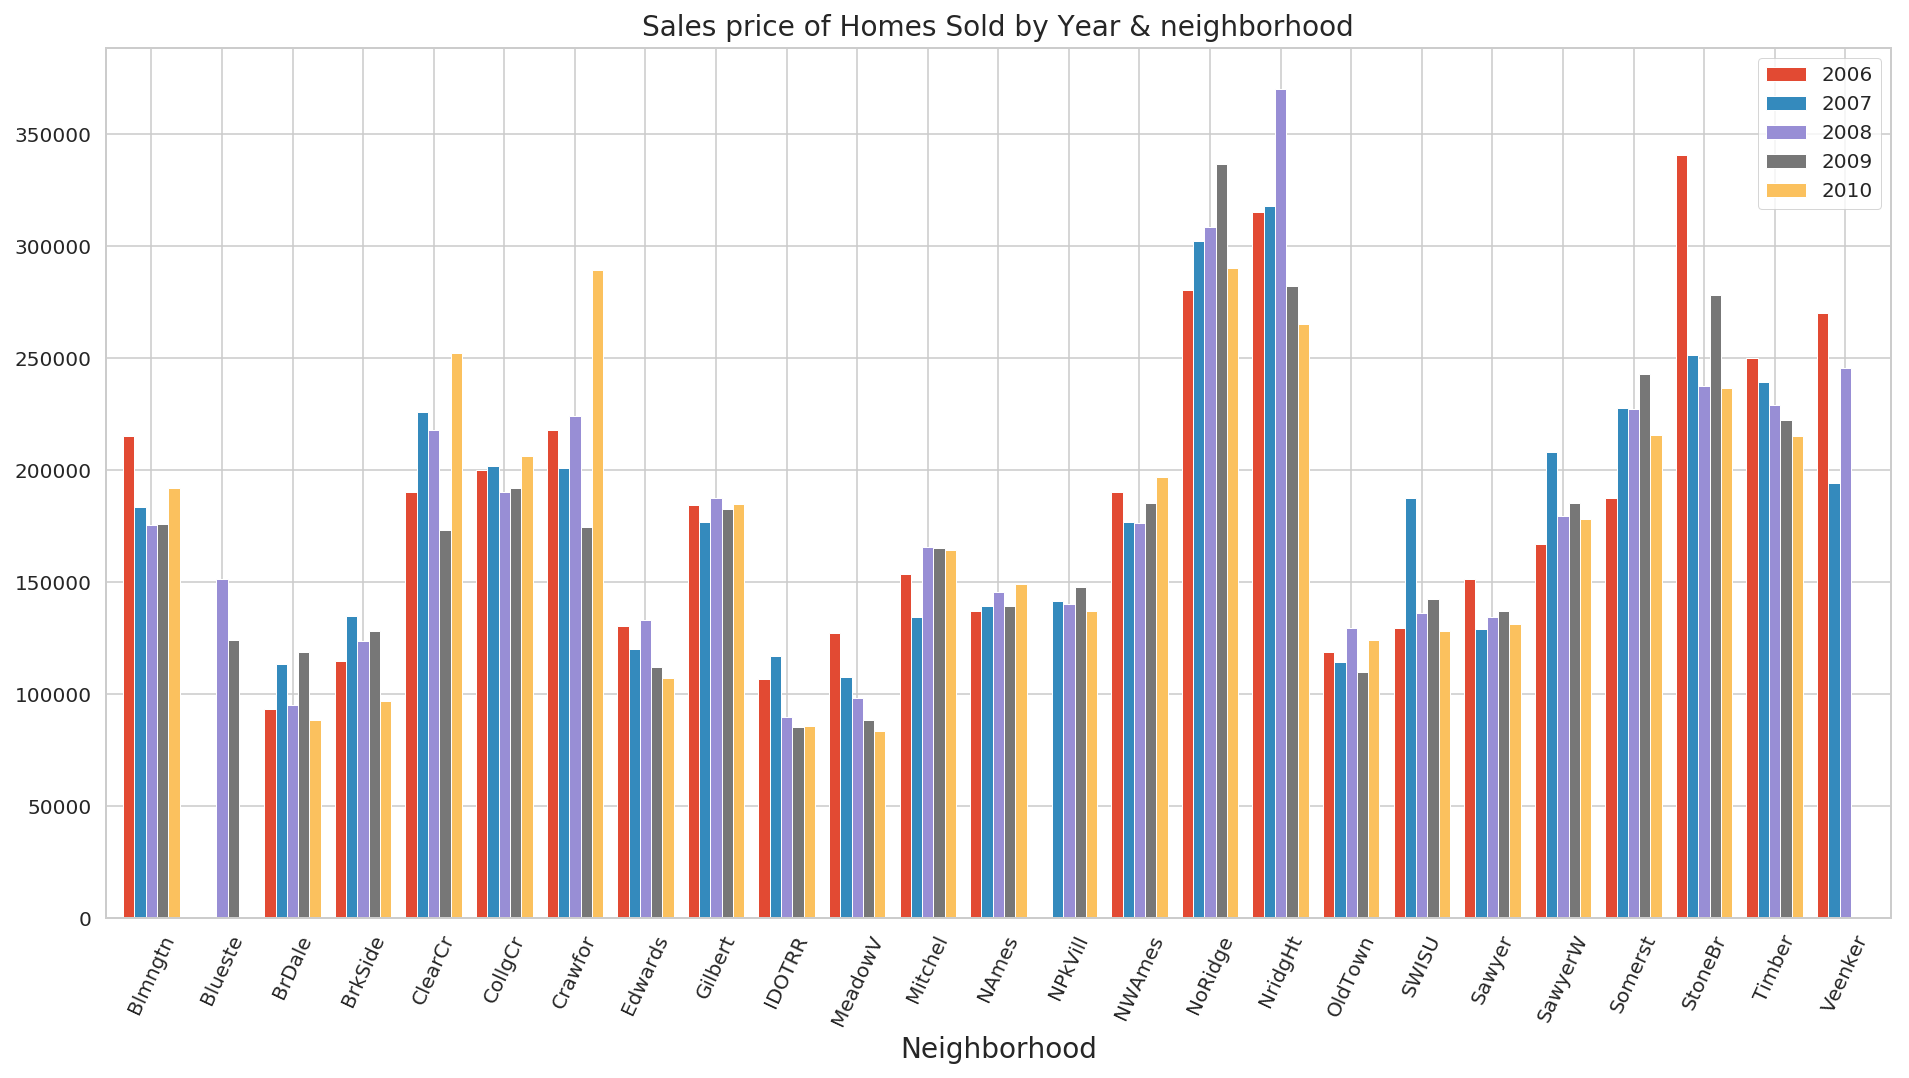

In [123]:
#plt.style.use('fivethirtyeight')
ax = pd.pivot_table(house, index=['Neighborhood'], values=['SalePrice'], columns = ['YrSold'], aggfunc=[np.median]).plot(kind='bar', rot=65, figsize=(16,8), width=.8)
ax.set_xlabel('Neighborhood', fontsize=14)
ax.set_title('Sales price of Homes Sold by Year & neighborhood', fontsize=14)
ax.legend(labels=['2006','2007','2008','2009','2010']);

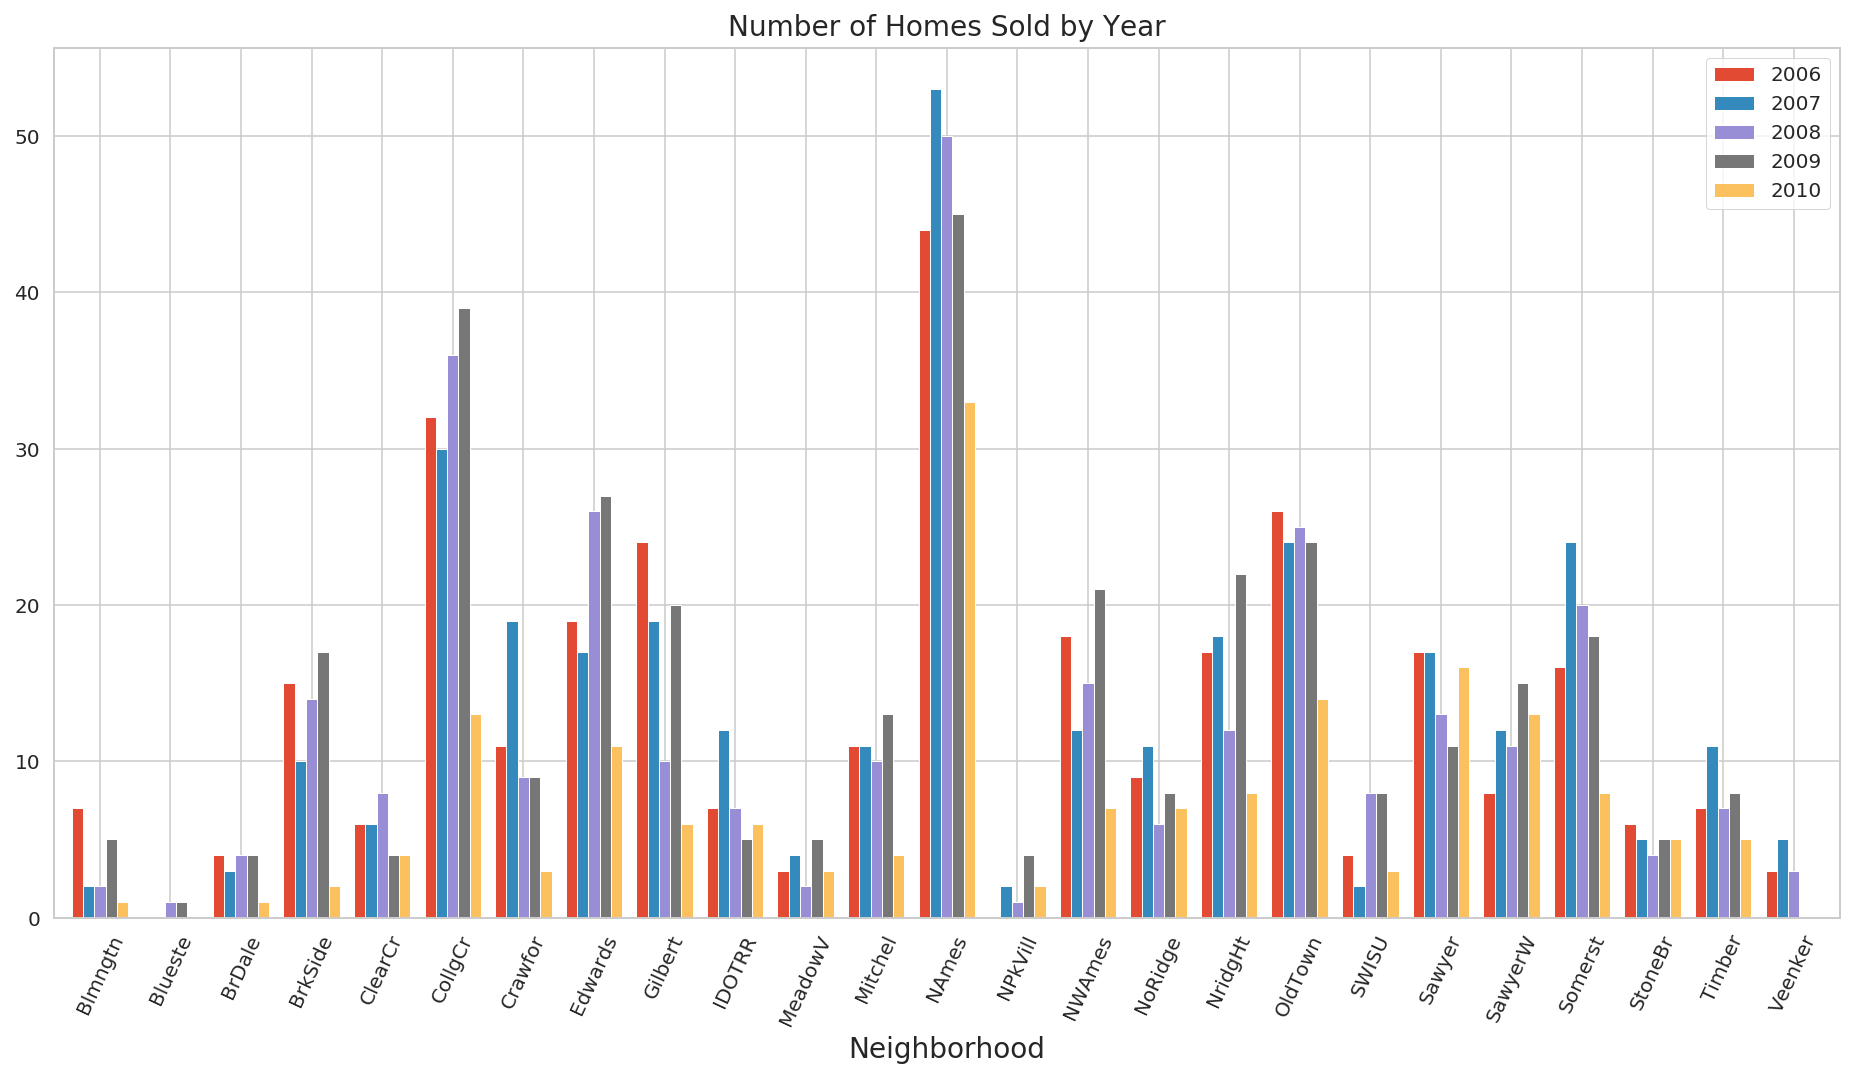

In [124]:
#plt.style.use('fivethirtyeight')
ax = pd.pivot_table(house, index=['Neighborhood'], values=['SalePrice'], columns = ['YrSold'], aggfunc=[len]).plot(kind='bar', rot=65, figsize=(16,8), width=.8)
ax.set_xlabel('Neighborhood', fontsize=14)
ax.set_title('Number of Homes Sold by Year', fontsize=14)
ax.legend(labels=['2006','2007','2008','2009','2010']);

In [125]:
house.MiscFeature.unique()

array(['None', 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

In [126]:
house[house.MiscFeature=='Othr'].MiscVal

705    3500
873       0
Name: MiscVal, dtype: int64

In [127]:
house.MiscVal.unique()

array([    0,   700,   350,   500,   400,   480,   450, 15500,  1200,
         800,  2000,   600,  3500,  1300,    54,   620,   560,  1400,
        8300,  1150,  2500])

In [128]:
house_var = house[house_var_col]
house_var.head(3)

,Id,Neighborhood,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior2nd,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,CollgCr,3,7,5,2003,2003,Gable,CompShg,VinylSd,...,0,0,None,None,0,2,2008,WD,Normal,208500
1,2,Veenker,3,6,8,1976,1976,Gable,CompShg,MetalSd,...,0,0,None,None,0,5,2007,WD,Normal,181500
2,3,CollgCr,3,7,5,2001,2002,Gable,CompShg,VinylSd,...,0,0,None,None,0,9,2008,WD,Normal,223500


 TO DO

 remove abnormal sale =  SaleCondition = Abnormal

MoSold: Month Sold (MM)

YrSold: Year Sold (YYYY)

SaleType: Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other
		
SaleCondition: Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)

In [129]:
house_var_price_columns = ['YearBuilt','YearRemodAdd' ,'MoSold', 'YrSold','SaleType','SalePrice','SaleCondition']

In [130]:
house_var_price = house_var[house_var_price_columns]

In [131]:
house_var_price.YrSold.min()    ## 2006 -2010

2006

In [132]:
house_var_price.YearBuilt.max()   #....1872 - 2010

2010

In [133]:
house_var_price.YearBuilt.max()   #....1872 - 2010

2010

In [134]:
house_var_price.YearRemodAdd.max()   # 1950 -2010

2010

In [135]:
house_var_solver = house_var[house_var['YearBuilt'] !=  house_var['YearRemodAdd']]

In [136]:
house_var_solver.shape

(696, 46)

In [137]:
house_var_test = house_var[house_var['YrSold'] ==  house_var['YearRemodAdd']]

In [138]:
#house_var_test

In [139]:
house_var_train = house_var[house_var['YrSold'] == 2010]

In [140]:
house_var_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175 entries, 16 to 1458
Data columns (total 46 columns):
Id               175 non-null int64
Neighborhood     175 non-null object
Utilities        175 non-null int64
OverallQual      175 non-null int64
OverallCond      175 non-null int64
YearBuilt        175 non-null int64
YearRemodAdd     175 non-null int64
RoofStyle        175 non-null object
RoofMatl         175 non-null object
Exterior2nd      175 non-null object
MasVnrType       175 non-null object
MasVnrArea       175 non-null float64
ExterQual        175 non-null int64
ExterCond        175 non-null int64
BsmtQual         175 non-null int64
BsmtCond         175 non-null int64
BsmtFinType2     175 non-null object
BsmtUnfSF        175 non-null int64
Heating          175 non-null object
HeatingQC        175 non-null int64
CentralAir       175 non-null int64
Electrical       175 non-null object
BsmtHalfBath     175 non-null int64
HalfBath         175 non-null int64
KitchenQual      17

In [141]:
##house_var_train

In [142]:
dum_MasVnrType = house_var_train[['MasVnrType']].copy()
dum_MasVnrType.head(10)

,MasVnrType
16,BrkFace
24,None
26,None
27,Stone
33,None
38,None
45,BrkFace
52,None
63,None
66,BrkFace


In [143]:
dum_Mas = pd.get_dummies(dum_MasVnrType)
dum_Mas.head()

,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone
16,0,1,0,0
24,0,0,1,0
26,0,0,1,0
27,0,0,0,1
33,0,0,1,0


In [144]:
for col in dum_Mas.columns:
    print(col)
    print(dum_Mas[col].value_counts())
    print('\n')

MasVnrType_BrkCmn
0    174
1      1
Name: MasVnrType_BrkCmn, dtype: int64


MasVnrType_BrkFace
0    122
1     53
Name: MasVnrType_BrkFace, dtype: int64


MasVnrType_None
1    105
0     70
Name: MasVnrType_None, dtype: int64


MasVnrType_Stone
0    159
1     16
Name: MasVnrType_Stone, dtype: int64




<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [145]:
# A:

#Feature selection using SelectFromModel and LassoCV — scikit-learn 0.20.3 documentation#
#https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_boston.html
    #sphx-glr-auto-examples-feature-selection-plot-select-from-model-boston-py